# Student Performance Prediction
this notebook predicts the performance of a student based on dataset

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.regression.linear_model import OLS
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy import stats
from sklearn.metrics import r2_score
from scipy.stats import jarque_bera, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import itertools
import requests
import zipfile
import os
import io
import base64
from io import BytesIO
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'

response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
math_df = pd.read_csv(z.open('student-mat.csv'), sep=';')
port_df = pd.read_csv(z.open('student-por.csv'), sep=';')

math_df['subject'] = 'math'
port_df['subject'] = 'portuguese'
df = pd.concat([math_df, port_df], ignore_index=True)

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Target variable (G3) statistics:")
print(df['G3'].describe())

Dataset shape: (1044, 34)
Missing values: 0
Target variable (G3) statistics:
count    1044.000000
mean       11.341954
std         3.864796
min         0.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: G3, dtype: float64


# Data Exploration

Data Types:
object    18
int64     16
Name: count, dtype: int64

Unique values in categorical columns:
school: 2 unique values
sex: 2 unique values
address: 2 unique values
famsize: 2 unique values
Pstatus: 2 unique values
Mjob: 5 unique values
Fjob: 5 unique values
reason: 4 unique values
guardian: 3 unique values
schoolsup: 2 unique values
famsup: 2 unique values
paid: 2 unique values
activities: 2 unique values
nursery: 2 unique values
higher: 2 unique values
internet: 2 unique values
romantic: 2 unique values
subject: 2 unique values


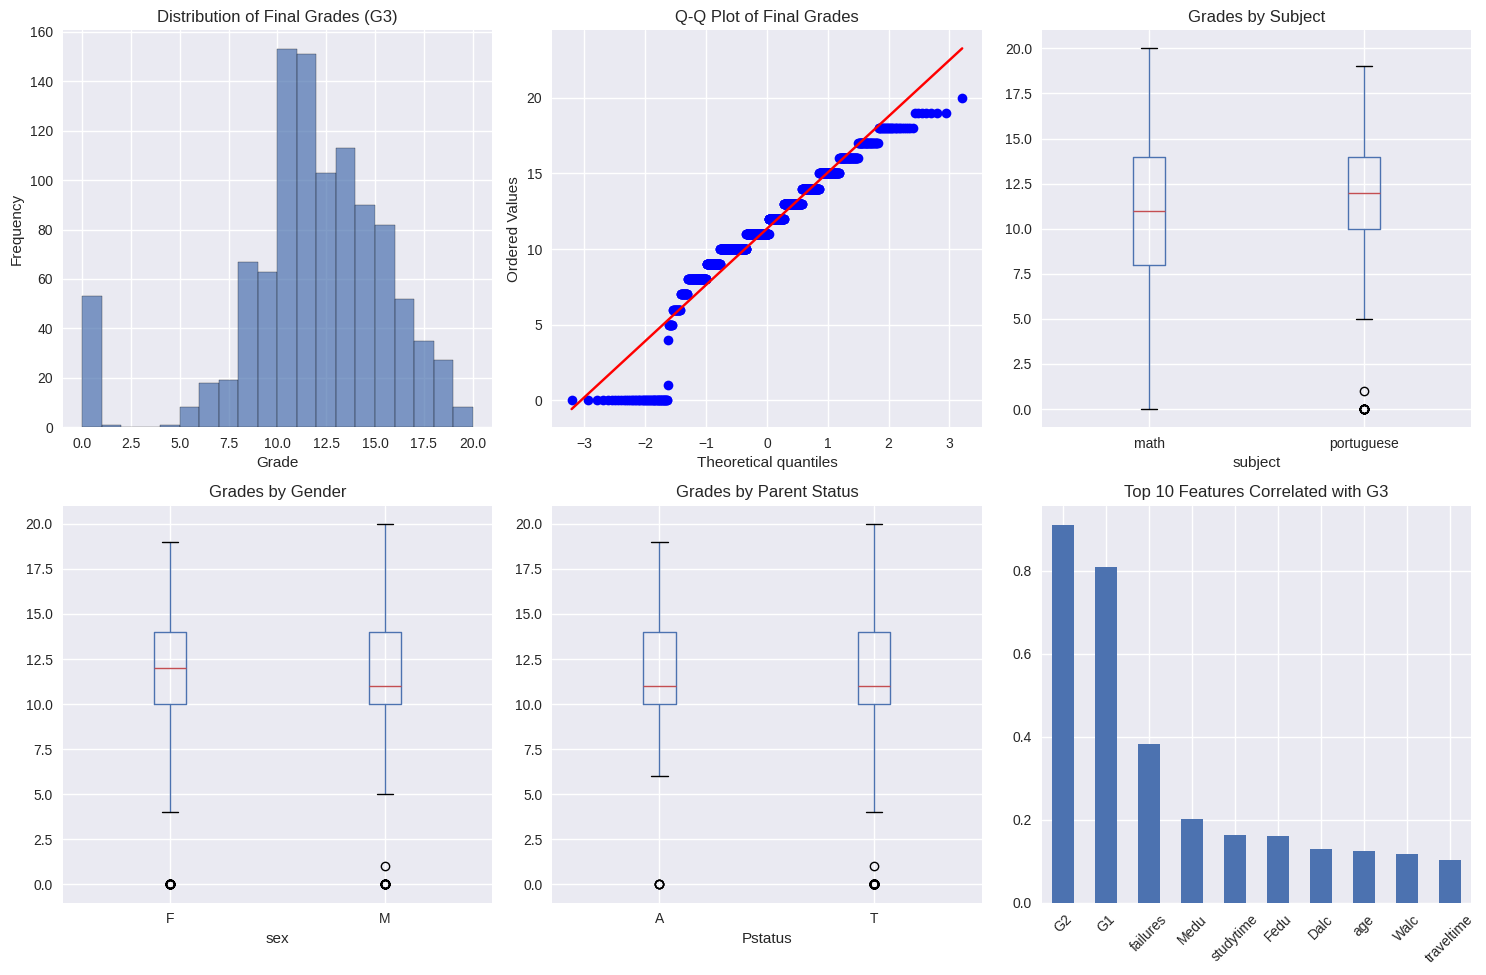

In [3]:
print("Data Types:")
print(df.dtypes.value_counts())
print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.hist(df['G3'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Grades (G3)')
plt.xlabel('Grade')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
stats.probplot(df['G3'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Final Grades')

plt.subplot(2, 3, 3)
df.boxplot(column='G3', by='subject', ax=plt.gca())
plt.title('Grades by Subject')
plt.suptitle('')

plt.subplot(2, 3, 4)
df.boxplot(column='G3', by='sex', ax=plt.gca())
plt.title('Grades by Gender')
plt.suptitle('')

plt.subplot(2, 3, 5)
df.boxplot(column='G3', by='Pstatus', ax=plt.gca())
plt.title('Grades by Parent Status')
plt.suptitle('')

plt.subplot(2, 3, 6)
numerical_df = df.select_dtypes(include=[np.number])
correlation_with_target = numerical_df.corr()['G3'].abs().sort_values(ascending=False)[1:11]
correlation_with_target.plot(kind='bar')
plt.title('Top 10 Features Correlated with G3')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical Tests and Distribution Analysis

In [4]:
jb_stat, jb_pvalue = jarque_bera(df['G3'])
shapiro_stat, shapiro_pvalue = stats.shapiro(df['G3'])
ks_stat, ks_pvalue = stats.kstest(df['G3'], 'norm', args=(df['G3'].mean(), df['G3'].std()))

print("Normality Tests for Target Variable (G3):")
print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_pvalue:.4f}")
print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

print("\nStatistical Tests Between Groups:")
male_grades = df[df['sex'] == 'M']['G3']
female_grades = df[df['sex'] == 'F']['G3']
t_stat, t_pvalue = stats.ttest_ind(male_grades, female_grades)
print(f"T-test (Male vs Female): t-statistic={t_stat:.4f}, p-value={t_pvalue:.4f}")

urban_grades = df[df['address'] == 'U']['G3']
rural_grades = df[df['address'] == 'R']['G3']
u_stat, u_pvalue = stats.mannwhitneyu(urban_grades, rural_grades)
print(f"Mann-Whitney U test (Urban vs Rural): U-statistic={u_stat:.4f}, p-value={u_pvalue:.4f}")

school_groups = [group['G3'].values for name, group in df.groupby('school')]
f_stat, f_pvalue = stats.f_oneway(*school_groups)
print(f"ANOVA (Schools): F-statistic={f_stat:.4f}, p-value={f_pvalue:.4f}")

Normality Tests for Target Variable (G3):
Jarque-Bera test: statistic=298.8906, p-value=0.0000
Shapiro-Wilk test: statistic=0.9183, p-value=0.0000
Kolmogorov-Smirnov test: statistic=0.1439, p-value=0.0000

Statistical Tests Between Groups:
T-test (Male vs Female): t-statistic=-1.0164, p-value=0.3097
Mann-Whitney U test (Urban vs Rural): U-statistic=126790.0000, p-value=0.0000
ANOVA (Schools): F-statistic=17.1131, p-value=0.0000


# Correlation and Relationship Analysis

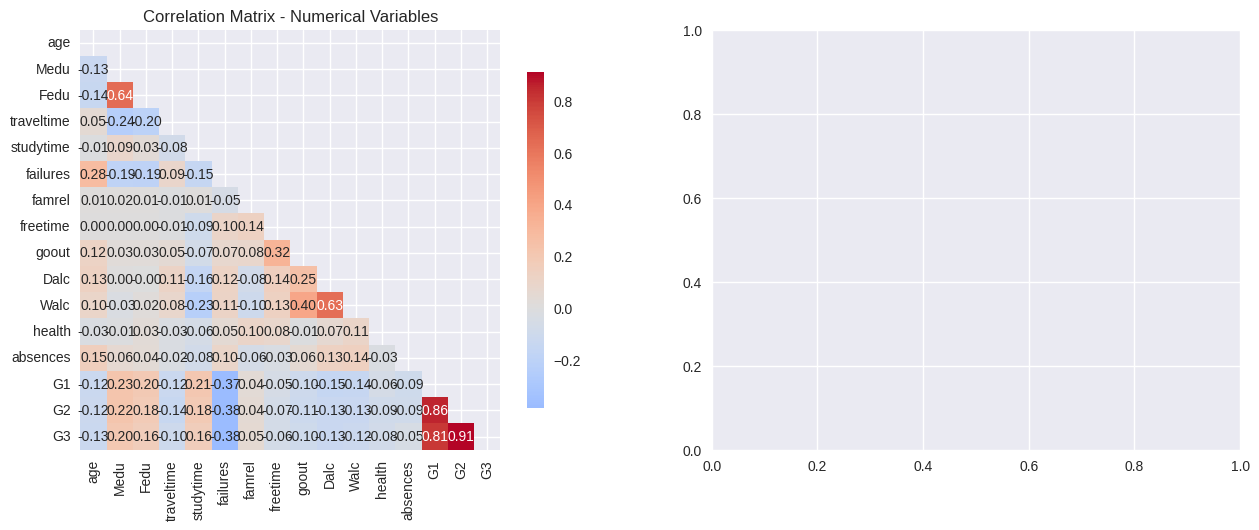

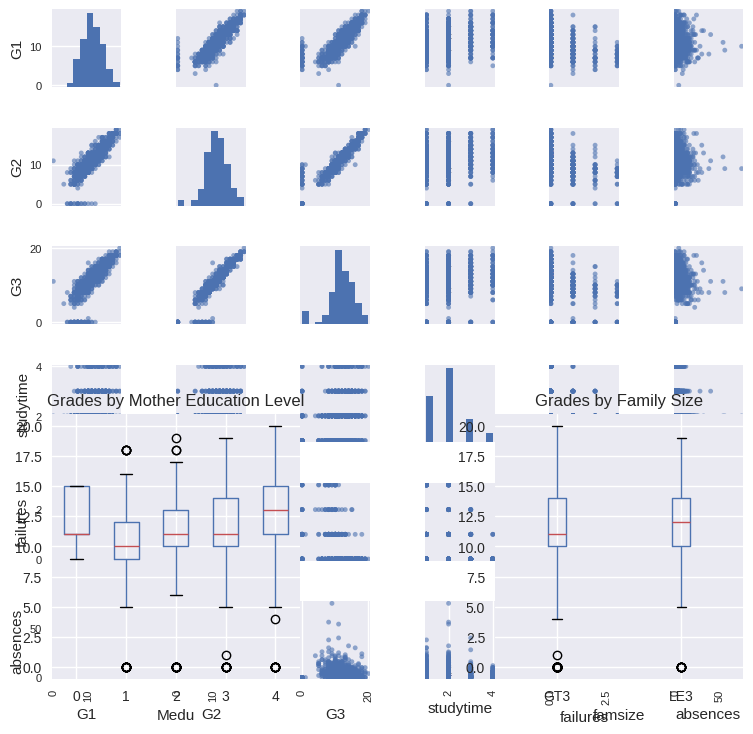

In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Variables')

key_vars = ['G1', 'G2', 'G3', 'studytime', 'failures', 'absences']
plt.subplot(2, 2, 2)
pd.plotting.scatter_matrix(df[key_vars], alpha=0.6, figsize=(8, 8), diagonal='hist')
plt.suptitle('Scatter Plot Matrix - Key Variables')

plt.subplot(2, 2, 3)
df.boxplot(column='G3', by='Medu', ax=plt.gca())
plt.title('Grades by Mother Education Level')
plt.suptitle('')

plt.subplot(2, 2, 4)
df.boxplot(column='G3', by='famsize', ax=plt.gca())
plt.title('Grades by Family Size')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Feature Engineering

In [6]:
df_processed = df.copy()

df_processed['grade_category'] = pd.cut(df_processed['G3'],
                                       bins=[0, 10, 15, 20],
                                       labels=['Low', 'Medium', 'High'], right=False)

df_processed['total_study_time'] = df_processed['studytime'] + df_processed['freetime']
df_processed['parent_education_avg'] = (df_processed['Medu'] + df_processed['Fedu']) / 2
df_processed['grade_trend'] = df_processed['G2'] - df_processed['G1']
df_processed['attendance_ratio'] = 1 - (df_processed['absences'] / df_processed['absences'].max())
df_processed['support_index'] = (df_processed['schoolsup'].map({'yes': 1, 'no': 0}) +
                                df_processed['famsup'].map({'yes': 1, 'no': 0}) +
                                df_processed['paid'].map({'yes': 1, 'no': 0}))

df_processed['family_quality'] = df_processed['famrel'] + df_processed['Pstatus'].map({'T': 2, 'A': 0})
df_processed['social_factor'] = df_processed['goout'] + df_processed['Dalc'] + df_processed['Walc']

df_processed['motivation_score'] = (df_processed['higher'].map({'yes': 2, 'no': 0}) +
                                   df_processed['internet'].map({'yes': 1, 'no': 0}) +
                                   df_processed['romantic'].map({'yes': -1, 'no': 1}))

print("New features created:")
new_features = ['grade_category', 'total_study_time', 'parent_education_avg', 'grade_trend',
                'attendance_ratio', 'support_index', 'family_quality', 'social_factor', 'motivation_score']
for feature in new_features:
    print(f"{feature}: {df_processed[feature].describe()}")

key_numerical = ['G1', 'G2', 'studytime', 'absences', 'age']
poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_data = poly_features.fit_transform(df_processed[key_numerical])
poly_feature_names = poly_features.get_feature_names_out(key_numerical)

for i, name in enumerate(poly_feature_names):
    if name not in key_numerical:
        df_processed[f'poly_{name}'] = poly_data[:, i]

df_processed['study_health_interaction'] = df_processed['studytime'] * df_processed['health']
df_processed['family_support_interaction'] = df_processed['parent_education_avg'] * df_processed['support_index']
df_processed['age_failures_interaction'] = df_processed['age'] * (df_processed['failures'] + 1)
df_processed['social_academic_balance'] = df_processed['social_factor'] / (df_processed['studytime'] + 1)

df_processed['age_group'] = pd.cut(df_processed['age'], bins=3, labels=['Young', 'Medium', 'Old'], right=False)
df_processed['absence_level'] = pd.cut(df_processed['absences'],
                                      bins=[-1, 0, 5, 15, 100],
                                      labels=['None', 'Low', 'Medium', 'High'], right=False)

skewed_features = ['absences']
for feature in skewed_features:
    df_processed[f'{feature}_log'] = np.log1p(df_processed[feature])

df_processed['g1_g2_ratio'] = df_processed['G1'] / (df_processed['G2'] + 1)
df_processed['study_absence_ratio'] = df_processed['studytime'] / (df_processed['absences'] + 1)

print(f"Total features after engineering: {df_processed.shape[1]}")
print(f"New polynomial features: {len([col for col in df_processed.columns if 'poly_' in col])}")

New features created:
grade_category: count       1043
unique         3
top       Medium
freq         610
Name: grade_category, dtype: object
total_study_time: count    1044.000000
mean        5.171456
std         1.263967
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: total_study_time, dtype: float64
parent_education_avg: count    1044.000000
mean        2.495690
std         1.007989
min         0.000000
25%         1.500000
50%         2.500000
75%         3.500000
max         4.000000
Name: parent_education_avg, dtype: float64
grade_trend: count    1044.000000
mean        0.032567
std         1.691129
min       -12.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: grade_trend, dtype: float64
attendance_ratio: count    1044.000000
mean        0.940868
std         0.082800
min         0.000000
25%         0.920000
50%         0.973333
75%         1.000000
max         1.000000

# Data Visualization Dashboard

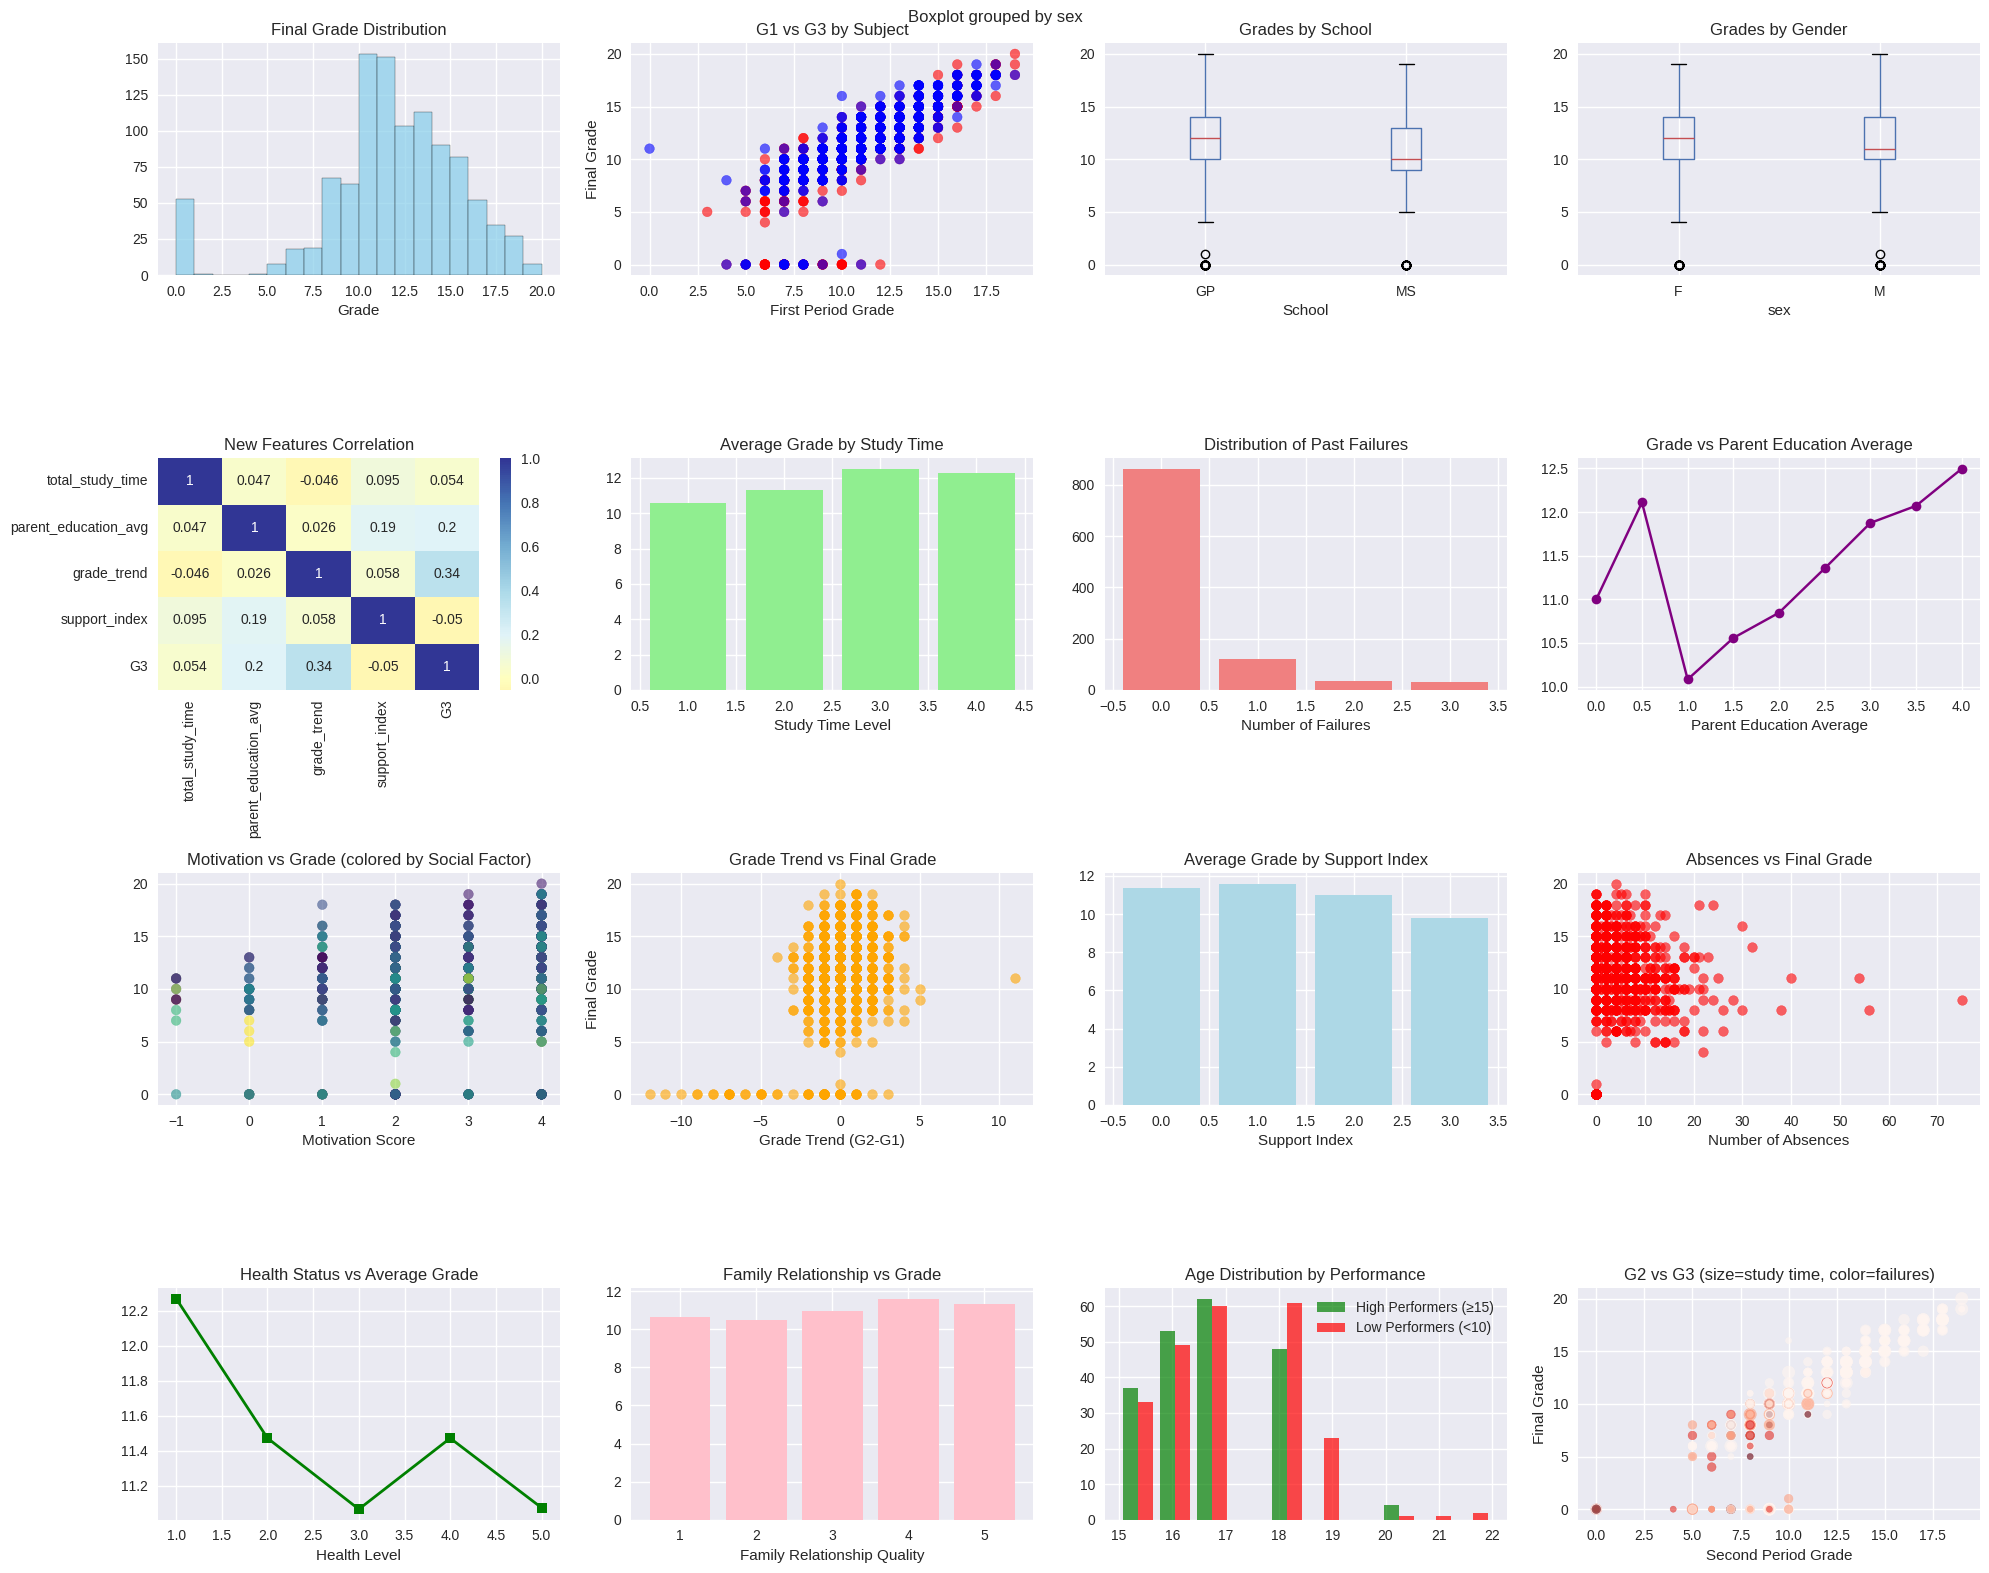

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Comprehensive Data Analysis Dashboard', fontsize=16)

axes[0, 0].hist(df_processed['G3'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Final Grade Distribution')
axes[0, 0].set_xlabel('Grade')

axes[0, 1].scatter(df_processed['G1'], df_processed['G3'], alpha=0.6, c=df_processed['subject'].map({'math': 'red', 'portuguese': 'blue'}))
axes[0, 1].set_title('G1 vs G3 by Subject')
axes[0, 1].set_xlabel('First Period Grade')
axes[0, 1].set_ylabel('Final Grade')

df_processed.boxplot(column='G3', by='school', ax=axes[0, 2])
axes[0, 2].set_title('Grades by School')
axes[0, 2].set_xlabel('School')

df_processed.boxplot(column='G3', by='sex', ax=axes[0, 3])
axes[0, 3].set_title('Grades by Gender')

new_numerical_features = ['total_study_time', 'parent_education_avg', 'grade_trend', 'support_index', 'G3']
corr_new = df_processed[new_numerical_features].corr()
sns.heatmap(corr_new, annot=True, cmap='RdYlBu', center=0, ax=axes[1, 0])
axes[1, 0].set_title('New Features Correlation')

study_time_grades = df_processed.groupby('studytime')['G3'].mean()
axes[1, 1].bar(study_time_grades.index, study_time_grades.values, color='lightgreen')
axes[1, 1].set_title('Average Grade by Study Time')
axes[1, 1].set_xlabel('Study Time Level')

failure_counts = df_processed['failures'].value_counts().sort_index()
axes[1, 2].bar(failure_counts.index, failure_counts.values, color='lightcoral')
axes[1, 2].set_title('Distribution of Past Failures')
axes[1, 2].set_xlabel('Number of Failures')

parent_edu_effect = df_processed.groupby('parent_education_avg')['G3'].mean()
axes[1, 3].plot(parent_edu_effect.index, parent_edu_effect.values, marker='o', color='purple')
axes[1, 3].set_title('Grade vs Parent Education Average')
axes[1, 3].set_xlabel('Parent Education Average')

axes[2, 0].scatter(df_processed['motivation_score'], df_processed['G3'],
                  c=df_processed['social_factor'], cmap='viridis', alpha=0.6)
axes[2, 0].set_title('Motivation vs Grade (colored by Social Factor)')
axes[2, 0].set_xlabel('Motivation Score')

axes[2, 1].scatter(df_processed['grade_trend'], df_processed['G3'], alpha=0.6, color='orange')
axes[2, 1].set_title('Grade Trend vs Final Grade')
axes[2, 1].set_xlabel('Grade Trend (G2-G1)')
axes[2, 1].set_ylabel('Final Grade')

support_grades = df_processed.groupby('support_index')['G3'].mean()
axes[2, 2].bar(support_grades.index, support_grades.values, color='lightblue')
axes[2, 2].set_title('Average Grade by Support Index')
axes[2, 2].set_xlabel('Support Index')

axes[2, 3].scatter(df_processed['absences'], df_processed['G3'], alpha=0.6, color='red')
axes[2, 3].set_title('Absences vs Final Grade')
axes[2, 3].set_xlabel('Number of Absences')

health_grades = df_processed.groupby('health')['G3'].mean()
axes[3, 0].plot(health_grades.index, health_grades.values, marker='s', color='green', linewidth=2)
axes[3, 0].set_title('Health Status vs Average Grade')
axes[3, 0].set_xlabel('Health Level')

famrel_grades = df_processed.groupby('famrel')['G3'].mean()
axes[3, 1].bar(famrel_grades.index, famrel_grades.values, color='pink')
axes[3, 1].set_title('Family Relationship vs Grade')
axes[3, 1].set_xlabel('Family Relationship Quality')

high_performers = df_processed[df_processed['G3'] >= 15]['age']
low_performers = df_processed[df_processed['G3'] < 10]['age']
axes[3, 2].hist([high_performers, low_performers], bins=10, alpha=0.7,
               label=['High Performers (≥15)', 'Low Performers (<10)'], color=['green', 'red'])
axes[3, 2].set_title('Age Distribution by Performance')
axes[3, 2].legend()

axes[3, 3].scatter(df_processed['G2'], df_processed['G3'],
                  s=df_processed['studytime']*20,
                  c=df_processed['failures'],
                  cmap='Reds', alpha=0.6)
axes[3, 3].set_title('G2 vs G3 (size=study time, color=failures)')
axes[3, 3].set_xlabel('Second Period Grade')
axes[3, 3].set_ylabel('Final Grade')

plt.tight_layout()
plt.show()

# Data Preprocessing and Scaling

In [8]:
target = 'G3'
features_to_drop = ['G3', 'grade_category']
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in features_to_drop]

df_encoded = df_processed.copy()
label_encoders = {}
for col in categorical_features:
    if df_encoded[col].dtype == 'bool':
        continue
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

high_cardinality_cats = ['reason', 'guardian', 'age_group', 'absence_level']
df_encoded = pd.get_dummies(df_encoded, columns=high_cardinality_cats, prefix=high_cardinality_cats)

X = df_encoded.drop(columns=features_to_drop)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=3, labels=False))

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")

scaler = StandardScaler()
numerical_cols_for_scaling = X_train.select_dtypes(include=np.number).columns
X_train_scaled = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_test_scaled = scaler.transform(X_test[numerical_cols_for_scaling])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols_for_scaling, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols_for_scaling, index=X_test.index)

X_train_final = pd.concat([X_train_scaled_df, X_train.select_dtypes(include='bool')], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test.select_dtypes(include='bool')], axis=1)

print("Data preprocessing completed")

Training set shape: (835, 70)
Test set shape: (209, 70)
Number of features: 70
Data preprocessing completed


# Model Definition and Hyperparameter Spaces

In [9]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {'fit_intercept': [True, False]}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10, 100],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'max_iter': [1000, 2000]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [1000, 2000]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 1.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [1, 10, 100],
            'gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance']
        }
    },
    'MLP': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'lbfgs'],
            'alpha': [0.0001, 0.001],
            'max_iter': [500, 1000]
        }
    }
}

print(f"Total models defined: {len(models)}")
print("Models:", list(models.keys()))

Total models defined: 11
Models: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'SVR', 'KNN', 'MLP']


# Model Training and Evaluation

In [10]:
results = {}
best_models = {}
cv_scores = {}

print("Starting model training and optimization...")
print("=" * 60)

for model_name, model_config in models.items():
    print(f"Training {model_name}...")

    try:
        random_search = RandomizedSearchCV(
            estimator=model_config['model'],
            param_distributions=model_config['params'],
            n_iter=20,
            cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42) if target in df_processed.columns and df_processed[target].nunique() > 10 else 3,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        X_train_model = X_train_final
        X_test_model = X_test_final

        random_search.fit(X_train_model, y_train)

        best_models[model_name] = random_search.best_estimator_

        cv_scores[model_name] = random_search.cv_results_['mean_test_score']


        y_pred = random_search.best_estimator_.predict(X_test_model)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)

        mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan).dropna())) * 100 if not y_test[y_test == 0].empty else np.nan
        max_error = np.max(np.abs(y_test - y_pred))

        results[model_name] = {
            'best_params': random_search.best_params_,
            'best_cv_score': random_search.best_score_,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'test_rmse': rmse,
            'test_mape': mape,
            'max_error': max_error,
            'predictions': y_pred
        }

        print(f"  Best CV R²: {random_search.best_score_:.4f}")
        print(f"  Test R²: {r2:.4f}")
        print(f"  Test RMSE: {rmse:.4f}")

    except Exception as e:
        print(f"  Error training {model_name}: {str(e)}")
        continue

print(f"\nModel training completed!")
print(f"Successfully trained {len(results)} models")

print("\nModel Performance Summary:")
print("-" * 60)
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_R2': [results[model]['best_cv_score'] for model in results.keys()],
    'Test_R2': [results[model]['test_r2'] for model in results.keys()],
    'Test_RMSE': [results[model]['test_rmse'] for model in results.keys()],
    'Test_MAE': [results[model]['test_mae'] for model in results.keys()],
    'Test_MAPE': [results[model].get('test_mape', np.nan) for model in results.keys()],
    'Max_Error': [results[model]['max_error'] for model in results.keys()]
})

performance_df = performance_df.sort_values('Test_R2', ascending=False)
print(performance_df.round(4))

top_3_models = performance_df.head(3)['Model'].tolist()
print(f"\nTop 3 performing models: {top_3_models}")

Starting model training and optimization...
Training LinearRegression...
  Best CV R²: 0.8393
  Test R²: 0.8284
  Test RMSE: 1.6518
Training Ridge...
  Best CV R²: 0.8455
  Test R²: 0.8306
  Test RMSE: 1.6414
Training Lasso...
  Best CV R²: 0.8479
  Test R²: 0.8319
  Test RMSE: 1.6349
Training ElasticNet...
  Best CV R²: 0.8475
  Test R²: 0.8313
  Test RMSE: 1.6377
Training DecisionTree...
  Best CV R²: 0.8446
  Test R²: 0.8278
  Test RMSE: 1.6549
Training RandomForest...
  Best CV R²: 0.8498
  Test R²: 0.8353
  Test RMSE: 1.6182
Training GradientBoosting...
  Best CV R²: 0.8510
  Test R²: 0.8412
  Test RMSE: 1.5889
Training AdaBoost...
  Best CV R²: 0.8369
  Test R²: 0.7871
  Test RMSE: 1.8401
Training SVR...
  Best CV R²: 0.8373
  Test R²: 0.8073
  Test RMSE: 1.7505
Training KNN...
  Best CV R²: 0.6827
  Test R²: 0.6450
  Test RMSE: 2.3759
Training MLP...
  Best CV R²: 0.8338
  Test R²: 0.8259
  Test RMSE: 1.6637

Model training completed!
Successfully trained 11 models

Model Perfor

# Model Evaluation and Statistical Analysis

In [11]:
def evaluate_model_comprehensively(model_name, y_true, y_pred, model_obj):
    """Comprehensive model evaluation with statistical tests"""

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)

    residuals = y_true - y_pred

    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    jb_stat, jb_p = jarque_bera(residuals)

    try:
        ols_model = OLS(residuals, np.column_stack([np.ones(len(y_pred)), y_pred])).fit()
        bp_stat, bp_p, _, _ = het_breuschpagan(ols_model.resid, ols_model.model.exog)
    except:
        bp_stat, bp_p = np.nan, np.nan

    dw_stat = durbin_watson(residuals)

    explained_variance = r2
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    residual_std = np.std(residuals)
    prediction_intervals = {
        '95%': 1.96 * residual_std,
        '90%': 1.645 * residual_std,
        '68%': 1.0 * residual_std
    }

    feature_importance = None
    if hasattr(model_obj, 'feature_importances_'):
        feature_importance = model_obj.feature_importances_
    elif hasattr(model_obj, 'coef_'):
        feature_importance = np.abs(model_obj.coef_)

    evaluation_results = {
        'model_name': model_name,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'jb_stat': jb_stat,
        'jb_p': jb_p,
        'bp_stat': bp_stat,
        'bp_p': bp_p,
        'dw_stat': dw_stat,
        'mean_residual': mean_residual,
        'std_residual': std_residual,
        'prediction_intervals': prediction_intervals,
        'feature_importance': feature_importance,
        'residuals': residuals
    }

    return evaluation_results

detailed_evaluations = {}
print("Detailed Model Evaluation Results:")
print("=" * 80)

for model_name in top_3_models:
    if model_name in results and model_name in best_models:
        y_pred = results[model_name]['predictions']
        model_obj = best_models[model_name]

        evaluation = evaluate_model_comprehensively(model_name, y_test, y_pred, model_obj)
        detailed_evaluations[model_name] = evaluation

        print(f"\n{model_name} Detailed Analysis:")
        print("-" * 50)
        print(f"R² Score: {evaluation['r2']:.4f}")
        print(f"RMSE: {evaluation['rmse']:.4f}")
        print(f"MAE: {evaluation['mae']:.4f}")
        print(f"Mean Residual: {evaluation['mean_residual']:.4f}")
        print(f"Residual Std: {evaluation['std_residual']:.4f}")
        print(f"Shapiro-Wilk p-value: {evaluation['shapiro_p']:.4f}")
        print(f"Jarque-Bera p-value: {evaluation['jb_p']:.4f}")
        print(f"Durbin-Watson stat: {evaluation['dw_stat']:.4f}")

        if not np.isnan(evaluation['bp_p']):
            print(f"Breusch-Pagan p-value: {evaluation['bp_p']:.4f}")

        print("Prediction Intervals:")
        for interval, value in evaluation['prediction_intervals'].items():
            print(f"  {interval}: ±{value:.4f}")

Detailed Model Evaluation Results:

GradientBoosting Detailed Analysis:
--------------------------------------------------
R² Score: 0.8412
RMSE: 1.5889
MAE: 0.9480
Mean Residual: -0.0538
Residual Std: 1.5880
Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
Durbin-Watson stat: 1.9082
Breusch-Pagan p-value: 0.0003
Prediction Intervals:
  95%: ±3.1124
  90%: ±2.6122
  68%: ±1.5880

RandomForest Detailed Analysis:
--------------------------------------------------
R² Score: 0.8353
RMSE: 1.6182
MAE: 0.9321
Mean Residual: -0.0485
Residual Std: 1.6175
Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
Durbin-Watson stat: 1.9054
Breusch-Pagan p-value: 0.0007
Prediction Intervals:
  95%: ±3.1703
  90%: ±2.6608
  68%: ±1.6175

Lasso Detailed Analysis:
--------------------------------------------------
R² Score: 0.8319
RMSE: 1.6349
MAE: 1.0044
Mean Residual: -0.0409
Residual Std: 1.6344
Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
Durbin-Watson stat: 1.9758
Breusch-Paga